# Partie 4 du document

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import fonctionsAKM
from tqdm import tqdm

In [2]:
#On commence par fixer le nombre de docteurs et le nombre de patients 

#Le nombre de docteurs:
nombre_docteur = 100
#Le nombre de patients:
nombre_patient = 100
#le nombre de clusters:
nombre_cluster =10

Dans le document on nous dit de prendre le modèle suivant :

 $D_{ij}= \mathbb{1}_{\{c + dX_{ij} - \alpha_{i} + \psi_{j} + V_{i,j}>0\}} $

 $Y_{i,j} = a + bX_{i,j} + \alpha_{i} - \psi_{j} + \epsilon_{i,j}$

 On a ici $\epsilon_{i,j} \sim \mathcal{N}(0,1)$ et $V_{i,j} \sim \mathcal{N}(0,1)$

 Pour correspondre au mieux à notre modèle, on va cependant se remettre sur la même base que dans la partie

$D_{i,j} \sim \mathcal{B}(1,\frac{e^{\lambda_{ij}}}{1+e^{\lambda_{ij}}})$ où:

 $\lambda_{ij}= c + dX_{ij} + \alpha_i + \psi_j $


In [3]:
#On s'occupe maintenant de créer les variables de notre modèle
#On se remet dans le même contexte que quand on appliquait AKM
## Ici on reprend donc juste le code de la partie AKM
a = 0
b = 3
c = 0
d = 4

#On commence par déterminer la position des individus sur le plan [0,1]*[0,1]
def position (n):
    return (np.random.uniform(0,1,size = (n)), np.random.uniform(0,1,size = (n)))
position_docteur = position(nombre_docteur)
position_patient = position(nombre_patient)

#On calcule la distance entre eux (notre Xij)
matrice_distance = np.zeros((nombre_patient, nombre_docteur))
for j in range(nombre_docteur):
    for i in range(nombre_patient):
        matrice_distance[i,j] = np.sqrt((position_patient[1][i]-position_docteur[1][j])**2+(position_patient[0][i]-position_docteur[0][j])**2)

#On crée les alpha_i et psi_j
alpha_d = np.random.randint(0,30,size=nombre_patient)/10
psi_d = np.random.randint(0,30,size=nombre_docteur)/10

alpha_y = np.random.randint(0,3,size=nombre_patient)
psi_y = np.random.randint(0,3,size=nombre_docteur)

#On crée les Dij
lien = np.zeros((nombre_patient,nombre_docteur))
for j in range(nombre_docteur):
    for i in range(nombre_patient):
        lambda_ij = c + d*matrice_distance[i,j]-alpha_d[i]+psi_d[j]
        lien[i,j] = np.random.binomial(1,1-(1/(1+np.exp(lambda_ij))))

#On crée ensuite les Yij
prix = np.zeros((nombre_patient,nombre_docteur))
for j in range(nombre_docteur):
    for i in range(nombre_patient):
        prix[i,j] = a + b*matrice_distance[i,j] + alpha_y[i] - psi_y[j] + np.random.normal(0,1)
        #Ici on avait pas mis la normal dans AKM, à discuter

prix_observe = prix*lien

In [4]:
lien.sum()

np.float64(7740.0)

In [5]:
if False:
    plt.figure(figsize=(6, 6))
    plt.scatter(position_docteur[0], position_docteur[1], color='blue', alpha=0.7, label="Docteur")
    plt.scatter(position_patient[0], position_patient[1], color='red', alpha=0.7, label="Patient")
    for i in range(nombre_patient):
        for j in range(nombre_docteur):
            if lien[i,j] == 1:
                plt.plot([position_docteur[0][j], position_patient[0][i]], [position_docteur[1][j], position_patient[1][i]], 'k-',alpha=0.5,color="green")
    plt.title("Points aléatoires uniformes dans [0,1]²")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(True)
    plt.axis('square')
    plt.legend()
    plt.show()

In [6]:
#On effectue maintenant la "two-step method"

#Commençons par l'étape de classification
Moment_1_i = lien.sum(axis=1)
Moment_2_i = (prix*lien).sum(axis=1)

Moment_1_j = lien.sum(axis=0)
Moment_2_j = (prix*lien).sum(axis=0)

ecart_type_i = []
for i in range(nombre_patient):
    vecteur_i = []
    for j in range(nombre_docteur):
        if prix_observe[i,j] >0:
            vecteur_i.append(prix_observe[i,j])
    std = np.std(vecteur_i, ddof=1)
    ecart_type_i.append(std)

ecart_type_j = []
for j in range(nombre_docteur):
    vecteur_j = []
    for i in range(nombre_patient):
        if prix_observe[i,j] >0:
            vecteur_j.append(prix_observe[i,j])
    std = np.std(vecteur_j, ddof=1)
    ecart_type_j.append(std)

In [7]:
Moment_1_i_ecart = Moment_1_i/np.array(ecart_type_i)
Moment_2_i_ecart = Moment_2_i/np.array(ecart_type_i)
Moment_1_j_ecart = Moment_1_j/np.array(ecart_type_j)
Moment_2_j_ecart = Moment_2_j/np.array(ecart_type_j)

In [8]:
print(Moment_1_i_ecart,Moment_1_j_ecart)

[108.7275669   74.93875737  85.96574329  78.7189355   52.83933636
  41.62535329  70.6065527   77.40750588  68.600984    62.79819974
  61.68094478  82.31543112  64.26540116  47.77605224  68.92303683
  74.83416722  51.06991367  80.51758877  66.04604382  63.92424248
  65.8829526   48.74724711 106.40629027  71.19433892  62.05393238
  83.57500604  66.04219557  41.10928109  69.26330997  60.47541171
  86.48852701  86.80079375  91.38557527  84.5019373   84.2121149
  76.79123435  56.35629674  61.23213524  82.9438002   65.72655833
  70.04600236  70.87279704  49.15904218  88.89537944  60.64989136
  54.91288017  46.07013041  68.09967796  81.24141118  65.20284784
  66.47328822  51.40342833  55.82919812  73.58487275  74.49763836
  53.75256194  66.69710025  61.195756    69.20655937  50.84659687
  71.87396255  73.48505634  81.31160754  59.63383467  64.34576238
  58.84056574  91.22925032  65.88433153  56.1390663   69.31996462
  73.87940332  53.58365022  75.12814694  59.10071986  71.9255577
  68.6664146

In [9]:
#Nous allons maintenant classifier les docteurs et les patients
#Nous utilisons k-means

from sklearn.cluster import KMeans
moments_patients = np.array([[Moment_1_i_ecart[i],Moment_2_i_ecart[i]] for i in range(len(Moment_1_i))])
kmeans_patients = KMeans(n_clusters=nombre_cluster)
labels_patients = kmeans_patients.fit_predict(moments_patients)
moments_docteurs = np.array([[Moment_1_j_ecart[j],Moment_2_j_ecart[j]] for j in range(len(Moment_1_j))])
kmeans_docteurs = KMeans(n_clusters=nombre_cluster)
labels_docteurs = kmeans_docteurs.fit_predict(moments_docteurs)

In [10]:
# Nous passons maintenant à la seconde étape de la two-step method

patient_ids = np.repeat(np.arange(nombre_patient), nombre_docteur)
doctor_ids = np.tile(np.arange(nombre_docteur), nombre_patient)

df = pd.DataFrame({
    'patient_id': patient_ids,
    'doctor_id': doctor_ids,
    'distance': matrice_distance.flatten(),
    'link': lien.flatten(),
    'prix': prix.flatten(),
    'prix_observe': prix_observe.flatten()
})

df

,patient_id,doctor_id,distance,link,prix,prix_observe
0,0,0,0.592227,1.0,2.415506,2.415506
1,0,1,0.591029,1.0,1.752615,1.752615
2,0,2,0.396348,1.0,0.476728,0.476728
3,0,3,0.283083,1.0,-1.572863,-1.572863
4,0,4,0.208356,1.0,-0.186815,-0.186815
...,...,...,...,...,...,...
9995,99,95,0.432470,1.0,-1.563205,-1.563205
9996,99,96,0.619578,1.0,1.835353,1.835353
9997,99,97,0.457430,1.0,-0.167768,-0.167768
9998,99,98,0.510294,1.0,2.186854,2.186854


In [11]:
patient_ids_petit = np.arange(nombre_patient)
patient_frame = pd.DataFrame({
    'patient_id': patient_ids_petit,
    'kmeans_patients': labels_patients
})

df = pd.merge(df, patient_frame, on='patient_id', how='left')

docteur_ids_petit = np.arange(nombre_docteur)
docteur_frame = pd.DataFrame({
    'doctor_id': docteur_ids_petit,
    'kmeans_doctors': labels_docteurs
})

df = pd.merge(df, docteur_frame, on='doctor_id', how='left')

In [12]:
df

,patient_id,doctor_id,distance,link,prix,prix_observe,kmeans_patients,kmeans_doctors
0,0,0,0.592227,1.0,2.415506,2.415506,6,5
1,0,1,0.591029,1.0,1.752615,1.752615,6,5
2,0,2,0.396348,1.0,0.476728,0.476728,6,5
3,0,3,0.283083,1.0,-1.572863,-1.572863,6,1
4,0,4,0.208356,1.0,-0.186815,-0.186815,6,1
...,...,...,...,...,...,...,...,...
9995,99,95,0.432470,1.0,-1.563205,-1.563205,1,7
9996,99,96,0.619578,1.0,1.835353,1.835353,1,2
9997,99,97,0.457430,1.0,-0.167768,-0.167768,1,6
9998,99,98,0.510294,1.0,2.186854,2.186854,1,8


In [13]:
# On crée des variables dummy pour les clusters obtenus par k-means
df_kmeans_dummies = pd.get_dummies(df['kmeans_patients'], prefix='cluster_patients')

# On ajoute les variables dummy au DataFrame
df = pd.concat([df, df_kmeans_dummies], axis=1)

In [14]:

df_kmeans_dummies = pd.get_dummies(df['kmeans_doctors'], prefix='cluster_doctors')

df = pd.concat([df, df_kmeans_dummies], axis=1)

In [15]:
df

,patient_id,doctor_id,distance,link,prix,prix_observe,kmeans_patients,kmeans_doctors,cluster_patients_0,cluster_patients_1,...,cluster_doctors_0,cluster_doctors_1,cluster_doctors_2,cluster_doctors_3,cluster_doctors_4,cluster_doctors_5,cluster_doctors_6,cluster_doctors_7,cluster_doctors_8,cluster_doctors_9
0,0,0,0.592227,1.0,2.415506,2.415506,6,5,False,False,...,False,False,False,False,False,True,False,False,False,False
1,0,1,0.591029,1.0,1.752615,1.752615,6,5,False,False,...,False,False,False,False,False,True,False,False,False,False
2,0,2,0.396348,1.0,0.476728,0.476728,6,5,False,False,...,False,False,False,False,False,True,False,False,False,False
3,0,3,0.283083,1.0,-1.572863,-1.572863,6,1,False,False,...,False,True,False,False,False,False,False,False,False,False
4,0,4,0.208356,1.0,-0.186815,-0.186815,6,1,False,False,...,False,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,99,95,0.432470,1.0,-1.563205,-1.563205,1,7,False,True,...,False,False,False,False,False,False,False,True,False,False
9996,99,96,0.619578,1.0,1.835353,1.835353,1,2,False,True,...,False,False,True,False,False,False,False,False,False,False
9997,99,97,0.457430,1.0,-0.167768,-0.167768,1,6,False,True,...,False,False,False,False,False,False,True,False,False,False
9998,99,98,0.510294,1.0,2.186854,2.186854,1,8,False,True,...,False,False,False,False,False,False,False,False,True,False


In [16]:
#On effectue les regressions
df_observed = df[df["link"] == 1]
X=pd.concat([df_observed[["distance"]]]+[df_observed[["cluster_patients_"+str(i)]] for i in range(nombre_cluster-1)]+[df_observed[["cluster_doctors_"+str(i)]] for i in range(nombre_cluster-1)], axis=1)
#X = pd.concat([df_observed[["distance"]], df_observed[["cluster_patients_0"]], df_observed[["cluster_patients_1"]], df_observed[["cluster_patients_2"]], df_observed[["cluster_patients_3"]], df_observed[["cluster_doctors_0"]], df_observed[["cluster_doctors_1"]], df_observed[["cluster_doctors_2"]], df_observed[["cluster_doctors_3"]]], axis=1)
X = sm.add_constant(X)
y = df_observed["prix"]
X = X.astype(float)
y = y.astype(float)
model = sm.OLS(y, X)              
results = model.fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                   prix   R-squared:                       0.625
Model:                            OLS   Adj. R-squared:                  0.624
Method:                 Least Squares   F-statistic:                     676.0
Date:                Sun, 04 May 2025   Prob (F-statistic):               0.00
Time:                        17:43:37   Log-Likelihood:                -11277.
No. Observations:                7740   AIC:                         2.259e+04
Df Residuals:                    7720   BIC:                         2.273e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.1228      0

In [17]:
#Ici on prend les mêmes alpha_i et psi_j pour les deux trucs, mais je crois que le prof disait qu'il fallait pas faire ça,
# mais j'ai l'impression que le doc fait ça donc à voir à adapter peut être

In [18]:
X_bis=pd.concat([df[["distance"]]]+[df[["cluster_patients_"+str(i)]] for i in range(nombre_cluster-1)]+[df[["cluster_doctors_"+str(i)]] for i in range(nombre_cluster-1)], axis=1)
#X_bis = pd.concat([df[["distance"]], df[["cluster_patients_0"]], df[["cluster_patients_1"]], df[["cluster_patients_2"]], df[["cluster_patients_3"]], df[["cluster_doctors_0"]], df[["cluster_doctors_1"]], df[["cluster_doctors_2"]], df[["cluster_doctors_3"]]], axis=1)
X_bis = sm.add_constant(X_bis)
d = df["link"]
X_bis = X_bis.astype(float)
d = d.astype(float)
logit_model = sm.Logit(d, X_bis)
logit_results = logit_model.fit()
print(logit_results.summary())

Optimization terminated successfully.
         Current function value: 0.434668
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                   link   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9980
Method:                           MLE   Df Model:                           19
Date:                Sun, 04 May 2025   Pseudo R-squ.:                  0.1866
Time:                        17:43:38   Log-Likelihood:                -4346.7
converged:                       True   LL-Null:                       -5344.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -1.2635      0.127     -9.969      0.000      -1.512      -1.015
dista

In [19]:
psi_d

array([2.4, 2.1, 2.5, 0.7, 0. , 1. , 0.2, 1.1, 1.9, 1.2, 1.9, 0.7, 1.7,
       1.5, 2.7, 0.6, 1.5, 2.4, 0.8, 0. , 1.8, 1.7, 0.8, 1.7, 1.1, 1.9,
       1.4, 1.1, 1.4, 0.9, 0.3, 0.7, 0.2, 1.2, 1.6, 1.7, 0.3, 2.7, 2.5,
       2.6, 0.3, 2.2, 2.8, 0.3, 0.9, 1.1, 1.4, 1.1, 1.5, 1.7, 2.1, 0.7,
       2.1, 2.5, 2.5, 2.4, 1.3, 2.5, 0. , 0.2, 1.3, 0.4, 2.7, 0. , 2.9,
       1.4, 1.8, 0.4, 1.9, 2.5, 0.5, 0.3, 2.6, 0.2, 1.7, 2.5, 1.1, 0.6,
       0.3, 0. , 0.4, 1.8, 0.7, 2.9, 2.3, 2.7, 1.8, 0.1, 0.8, 1.3, 1. ,
       0.4, 0. , 2.9, 1.3, 2.6, 0.1, 1.6, 2.8, 1.9])

In [20]:
labels_docteurs

array([5, 5, 5, 1, 1, 6, 1, 2, 9, 2, 7, 2, 8, 6, 5, 1, 8, 8, 0, 9, 8, 3,
       8, 2, 8, 3, 9, 0, 2, 0, 2, 9, 1, 9, 6, 6, 2, 7, 6, 3, 6, 8, 5, 9,
       1, 1, 0, 0, 6, 9, 7, 1, 8, 5, 8, 6, 5, 5, 4, 0, 2, 0, 5, 0, 6, 6,
       0, 9, 8, 5, 4, 2, 8, 1, 8, 8, 5, 2, 0, 4, 9, 0, 1, 3, 5, 6, 2, 0,
       5, 3, 0, 4, 4, 5, 6, 7, 2, 6, 8, 6], dtype=int32)

In [21]:
a=[]
for i in range(nombre_cluster):
    ids=list(df[df['cluster_doctors_'+str(i)]==True]['doctor_id'])
    a.append(np.average([psi_d[i] for i in ids]))
labels_docteurs_average=[a[i] for i in labels_docteurs]


In [22]:
print(np.corrcoef(psi_d, labels_docteurs_average)[0, 1])

0.7664329193712234


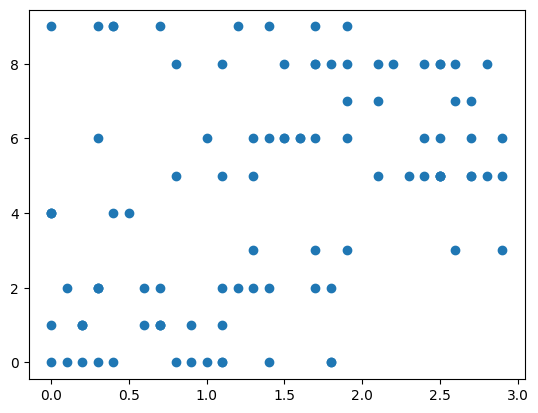

In [23]:
plt.scatter(psi_d, labels_docteurs)

In [24]:
import seaborn as sns

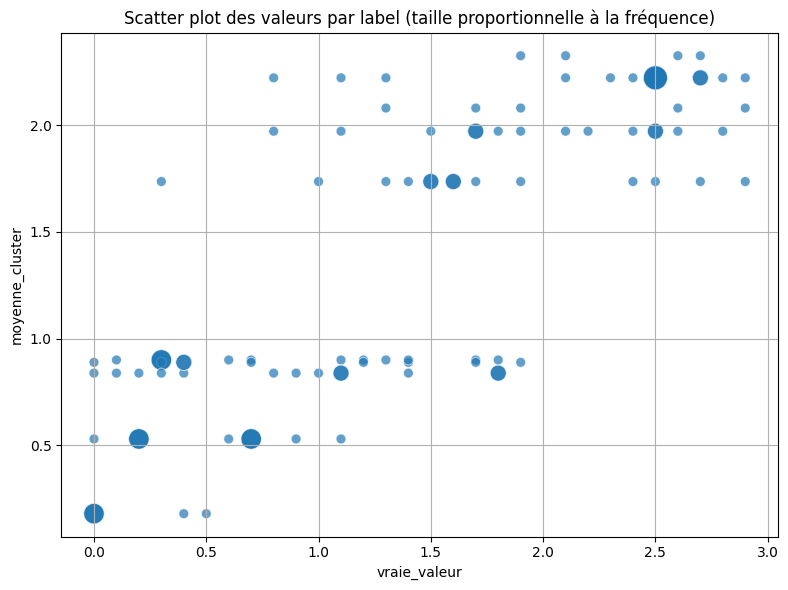

In [25]:
df4 = pd.DataFrame({'vraie_valeur': psi_d, 'moyenne_cluster': labels_docteurs_average})

# 3. Compter les occurrences de chaque (valeur, label)
df4['count'] = df4.groupby(['vraie_valeur', 'moyenne_cluster'])['moyenne_cluster'].transform('count')

# 4. Afficher le scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df4,
    x='vraie_valeur',
    y='moyenne_cluster',
    size='count',        # la taille dépend de la fréquence
    sizes=(50, 300),     # taille minimale et maximale
    legend=False,
    alpha=0.7
)

plt.title('Scatter plot des valeurs par label (taille proportionnelle à la fréquence)')
plt.xlabel('vraie_valeur')
plt.ylabel('moyenne_cluster')
plt.grid(True)
plt.tight_layout()
plt.show()